# Taxi Demand Prediction by Zone and Date

This notebook demonstrates a complete workflow for predicting taxi demand using zone, date, and weather data. It includes:
- Data loading and merging
- Feature engineering
- Model training (LightGBM)
- Evaluation metrics (MAE, RMSE, R²)
- Actual vs Predicted comparison plots
- Prediction function for any zone/date/hour



In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load all zone data with PUZone consistency filtering
zone_files = sorted(glob.glob('data/2025-*_1H_zone.csv'))
file_dfs = []
zone_counts = {}
for f in zone_files:
    try:
        tmp = pd.read_csv(f)
        if 'Unnamed: 0' in tmp.columns:
            tmp = tmp.drop(columns=['Unnamed: 0'])
        if {'PUZone', 'PUTime', 'Count'}.issubset(tmp.columns):
            zone_counts[f] = tmp['PUZone'].nunique()
            file_dfs.append((f, tmp))
    except Exception as e:
        print(f"Skip {f}: {e}")

if not file_dfs:
    raise RuntimeError('No valid zone files found.')

from collections import Counter
mode_count = Counter(zone_counts.values()).most_common(1)[0][0]
kept = [df for f, df in file_dfs if zone_counts.get(f) == mode_count]
if len(kept) < len(file_dfs):
    dropped = [f for f, _ in file_dfs if zone_counts.get(f) != mode_count]
    print('Excluded files due to inconsistent PUZone count:', dropped)

df = pd.concat(kept, ignore_index=True)

# Drop index column if present (safety)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Load weather data
weather = pd.read_csv('data/weather_2025.csv')



In [2]:
# Convert PUTime to datetime
if not np.issubdtype(df['PUTime'].dtype, np.datetime64):
    df['PUTime'] = pd.to_datetime(df['PUTime'])
df['date'] = df['PUTime'].dt.date

# Prepare weather data
def parse_weather_date(x):
    try:
        return pd.to_datetime(x, format='%m/%d/%y')
    except:
        return pd.to_datetime(x)
weather['DATE'] = weather['DATE'].apply(parse_weather_date)
weather['date'] = weather['DATE'].dt.date

# Merge on date
merged = df.merge(weather, on='date', how='left')



In [3]:
# Feature engineering
merged['hour'] = merged['PUTime'].dt.hour
merged['weekday'] = merged['PUTime'].dt.weekday
merged['month'] = merged['PUTime'].dt.month
merged['PUZone'] = merged['PUZone'].astype('category')

# Fill missing weather values with 0 (except for date columns)
weather_cols = weather.columns.drop(['DATE', 'date'])
merged[weather_cols] = merged[weather_cols].fillna(0)

# Features and target
target_col = 'Count'
feature_cols = ['PUZone', 'hour', 'weekday', 'month'] + list(weather_cols)
X = merged[feature_cols]
y = merged[target_col]



In [4]:
# Time-based train/test split (80% train, 20% test)
split_time = merged['PUTime'].quantile(0.8)
X_train = X[merged['PUTime'] < split_time]
y_train = y[merged['PUTime'] < split_time]
X_test = X[merged['PUTime'] >= split_time]
y_test = y[merged['PUTime'] >= split_time]



In [5]:
# Model training (LightGBM)
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train, categorical_feature=['PUZone'])



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 211627, number of used features: 19
[LightGBM] [Info] Start training from score 158.409674


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [6]:
# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")



Test MAE: 38.92
Test RMSE: 72.94
Test R²: 0.8646


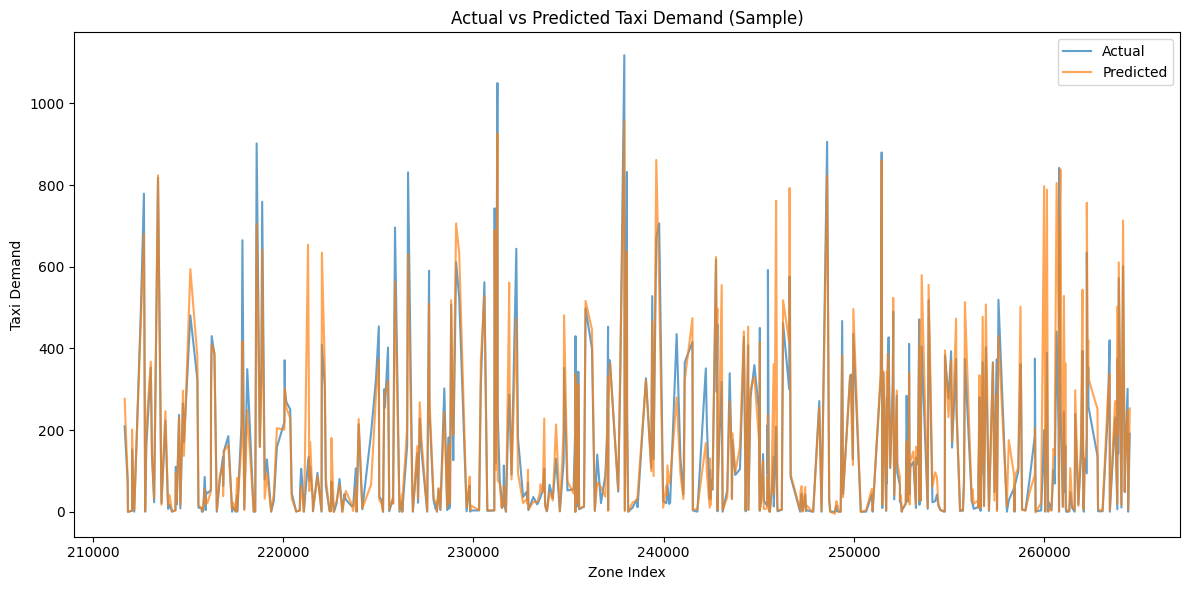

In [7]:
# Actual vs Predicted comparison plot
import matplotlib.pyplot as plt

# Plot for a random sample of 500 points for clarity
sample = X_test.copy()
sample['Actual'] = y_test
sample['Predicted'] = y_pred
sample = sample.sample(n=min(500, len(sample)), random_state=42).sort_index()

plt.figure(figsize=(12, 6))
plt.plot(sample.index, sample['Actual'], label='Actual', alpha=0.7)
plt.plot(sample.index, sample['Predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Taxi Demand (Sample)')
plt.xlabel('Zone Index')
plt.ylabel('Taxi Demand')
plt.legend()
plt.tight_layout()
plt.show()



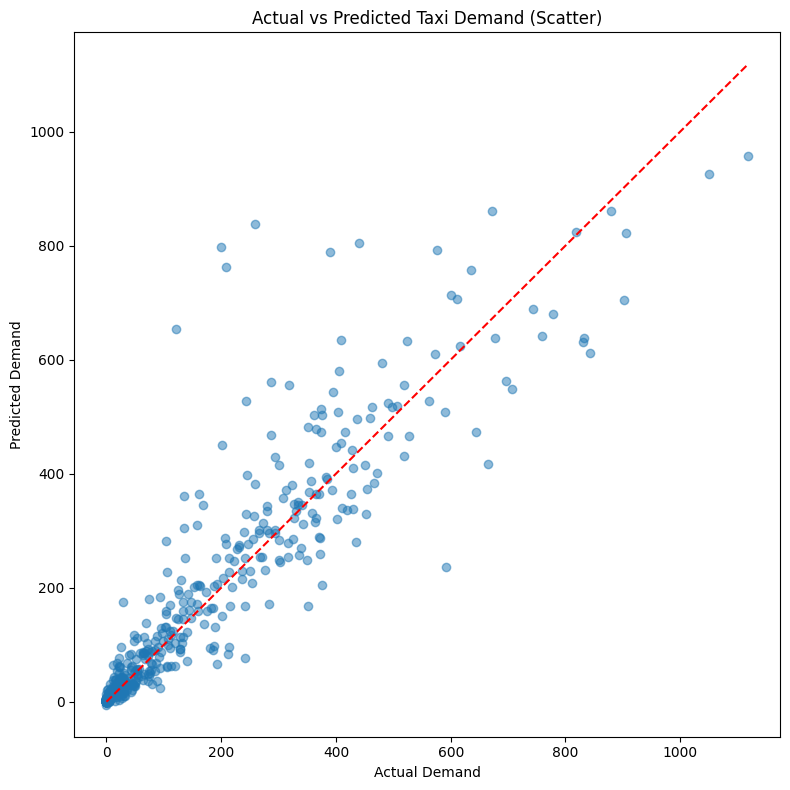

In [8]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(sample['Actual'], sample['Predicted'], alpha=0.5)
plt.plot([sample['Actual'].min(), sample['Actual'].max()], [sample['Actual'].min(), sample['Actual'].max()], 'r--')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Actual vs Predicted Taxi Demand (Scatter)')
plt.tight_layout()
plt.show()



In [9]:
# Prediction function for any zone/date/hour

def predict_demand(zone, date_str, hour, weather_df=weather):
    date = pd.to_datetime(date_str)
    weekday = date.weekday()
    month = date.month
    # Find weather for this date
    w = weather_df[weather_df['date'] == date.date()]
    if w.empty:
        w = pd.DataFrame([np.zeros(len(weather_cols))], columns=weather_cols)
    else:
        w = w[weather_cols]
    features = pd.DataFrame([{
        'PUZone': zone,
        'hour': hour,
        'weekday': weekday,
        'month': month,
        **dict(zip(weather_cols, w.iloc[0]))
    }])
    features['PUZone'] = features['PUZone'].astype('category')
    return model.predict(features)[0]

# Example usage:
print('Predicted demand for Zone 5, 2025-08-15 14:00:', predict_demand(5, '2025-08-15', 14))



Predicted demand for Zone 5, 2025-08-15 14:00: -0.7914309638063094


In [10]:
# 1. Import all models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor



In [ ]:
# 2. Define model list - Only 4 algorithms: CatBoost, XGBoost, HistGradient, LightGBM
models = [
    ('CatBoost', CatBoostRegressor(verbose=0, random_state=42, n_estimators=100)),
    ('XGBoost', xgb.XGBRegressor(n_estimators=100, tree_method='hist', enable_categorical=False, random_state=42, verbosity=0, n_jobs=-1)),
    ('HistGradientBoosting', HistGradientBoostingRegressor(random_state=42)),
    ('LightGBM', lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
]

# Remove any duplicate model names (keep first occurrence only)
seen = set()
unique_models = []
for name, model in models:
    if name not in seen:
        unique_models.append((name, model))
        seen.add(name)
models = unique_models

# Use all training data for better accuracy
X_train_sample = X_train
y_train_sample = y_train



In [ ]:
# Duplicate removal is now handled in the model definition cell above



In [13]:
# Add more powerful models and a stacking ensemble for higher accuracy
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

# Add CatBoost, ExtraTrees, GradientBoosting
models += [
    ('CatBoost', CatBoostRegressor(verbose=0, random_state=42, n_estimators=100)),
    ('ExtraTrees', ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=42)),
    ('GradientBoosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
]

# Stacking ensemble (meta-model: Ridge, base: LGBM, XGB, CatBoost)
stack = StackingRegressor(
    estimators=[
        ('lgbm', lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
        ('xgb', xgb.XGBRegressor(n_estimators=100, tree_method='hist', enable_categorical=False, random_state=42, verbosity=0, n_jobs=-1)),
        ('cat', CatBoostRegressor(verbose=0, random_state=42, n_estimators=100))
    ],
    final_estimator=Ridge()
)
models.append(('Stacking', stack))



In [14]:
# 3. Train, predict, and collect metrics for all models (CatBoost, XGBoost, HistGradient, LightGBM)
results = []
for name, model in models:
    try:
        if name == 'LightGBM':
            model.fit(X_train_sample, y_train_sample, categorical_feature=['PUZone'])
            y_pred = model.predict(X_test)
        elif name == 'XGBoost':
            X_train_xgb = X_train_sample.copy()
            X_test_xgb = X_test.copy()
            X_train_xgb['PUZone'] = X_train_xgb['PUZone'].astype(int)
            X_test_xgb['PUZone'] = X_test_xgb['PUZone'].astype(int)
            model.fit(X_train_xgb, y_train_sample)
            y_pred = model.predict(X_test_xgb)
        elif name == 'CatBoost':
            X_train_cb = X_train_sample.copy()
            X_test_cb = X_test.copy()
            X_train_cb['PUZone'] = X_train_cb['PUZone'].astype(str)
            X_test_cb['PUZone'] = X_test_cb['PUZone'].astype(str)
            model.fit(X_train_cb, y_train_sample, cat_features=['PUZone'])
            y_pred = model.predict(X_test_cb)
        else:  # HistGradientBoosting
            model.fit(X_train_sample, y_train_sample)
            y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    except Exception as e:
        print(f"{name} failed: {e}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 211627, number of used features: 19
[LightGBM] [Info] Start training from score 158.409674
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 211627, number of used features: 19
[LightGBM] [Info] Start training from score 158.409674
Stacking failed: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set t

,Model,MAE,RMSE,R2
5,ExtraTrees,36.051557,71.389182,0.870236
3,LightGBM,38.921369,72.936487,0.864550
2,HistGradientBoosting,38.770778,73.201838,0.863563
1,XGBoost,45.579201,74.972856,0.856881
0,CatBoost,63.772555,107.579918,0.705320
4,CatBoost,63.772555,107.579918,0.705320
6,GradientBoosting,76.222848,110.432172,0.689487


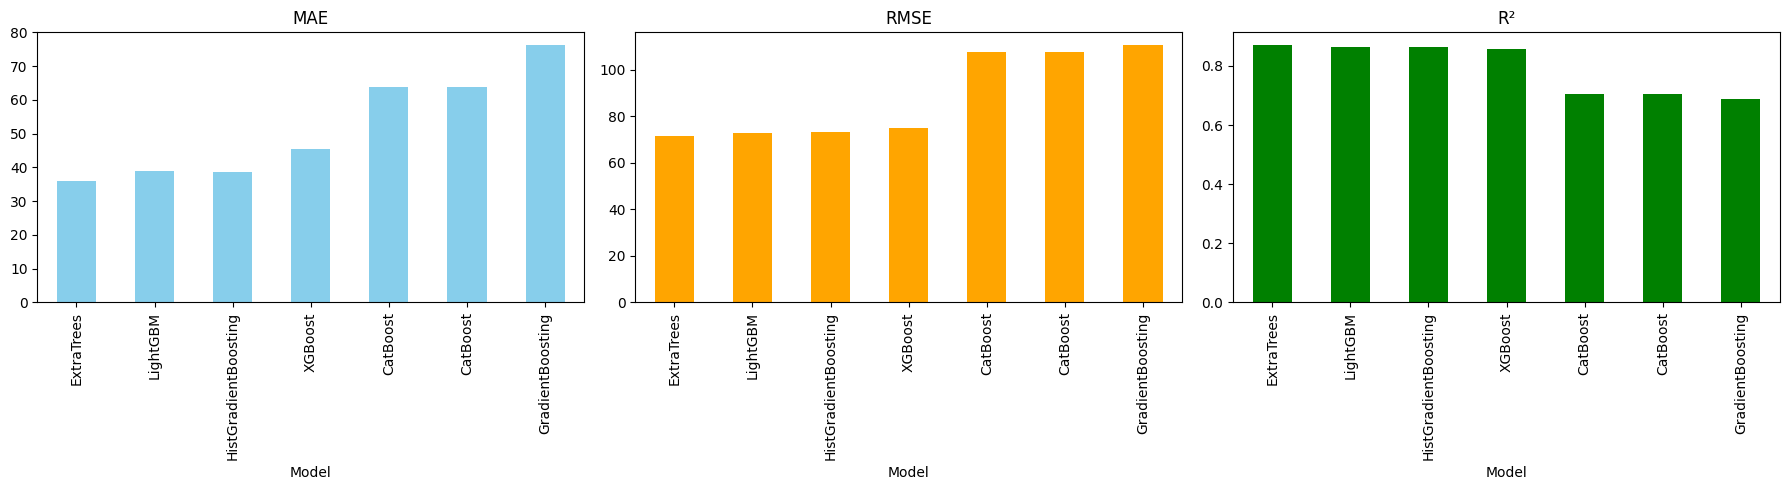

In [15]:
# 4. Results DataFrame and comparison plots
results_df = pd.DataFrame(results).sort_values('RMSE')
display(results_df)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results_df.plot.bar(x='Model', y='MAE', ax=axes[0], legend=False, color='skyblue')
axes[0].set_title('MAE')
results_df.plot.bar(x='Model', y='RMSE', ax=axes[1], legend=False, color='orange')
axes[1].set_title('RMSE')
results_df.plot.bar(x='Model', y='R2', ax=axes[2], legend=False, color='green')
axes[2].set_title('R²')
plt.tight_layout()
plt.show()



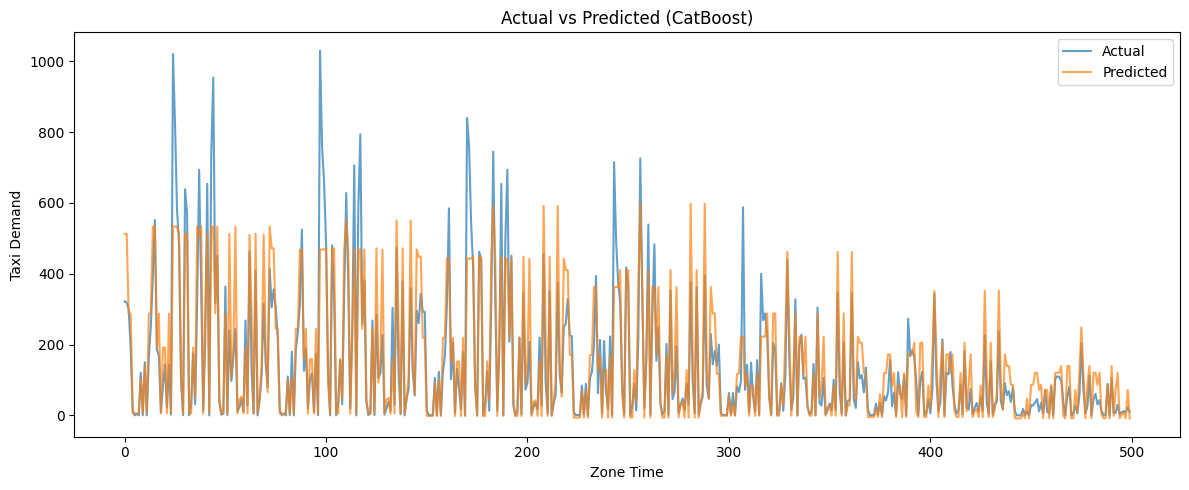

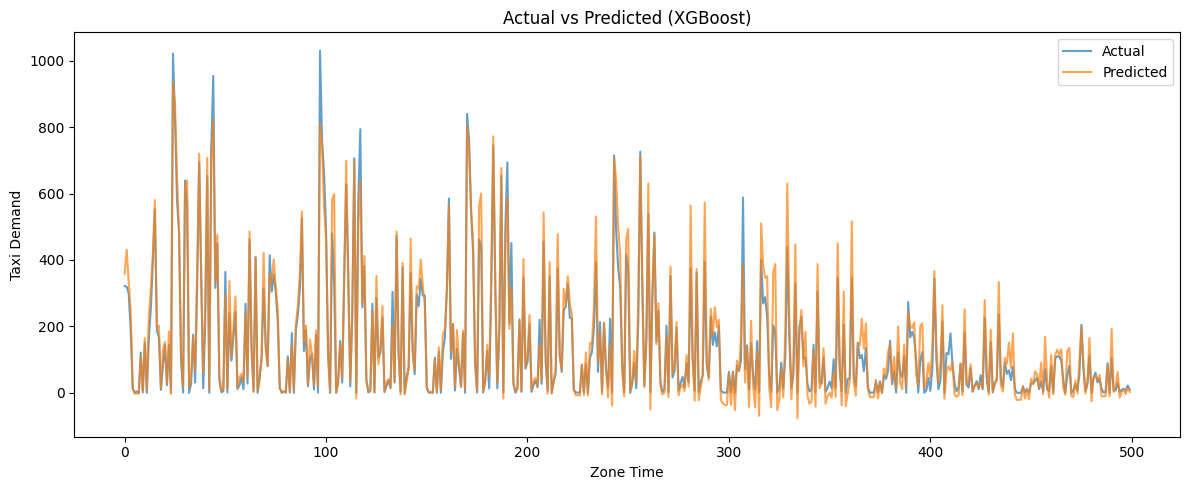

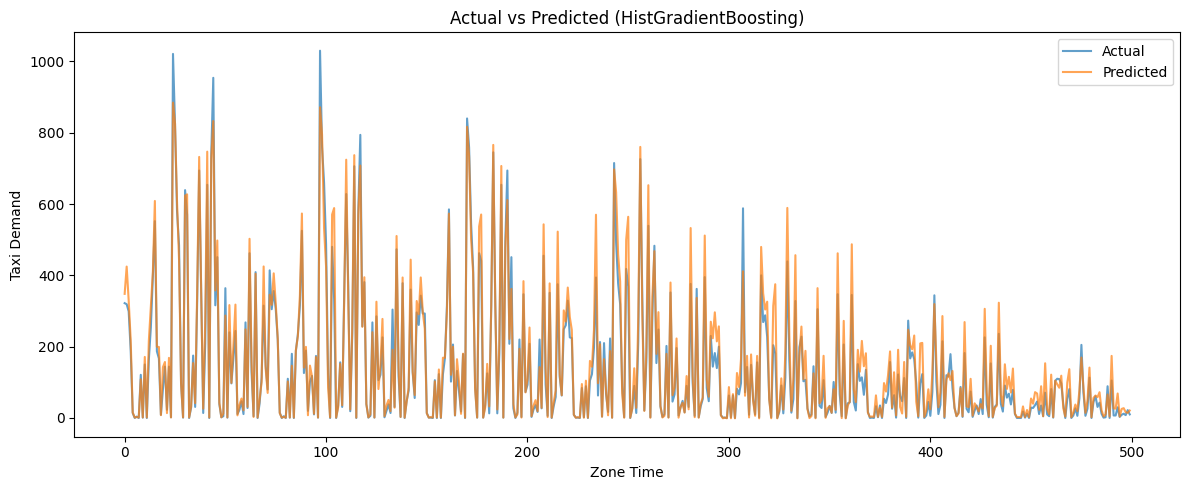

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 211627, number of used features: 19
[LightGBM] [Info] Start training from score 158.409674


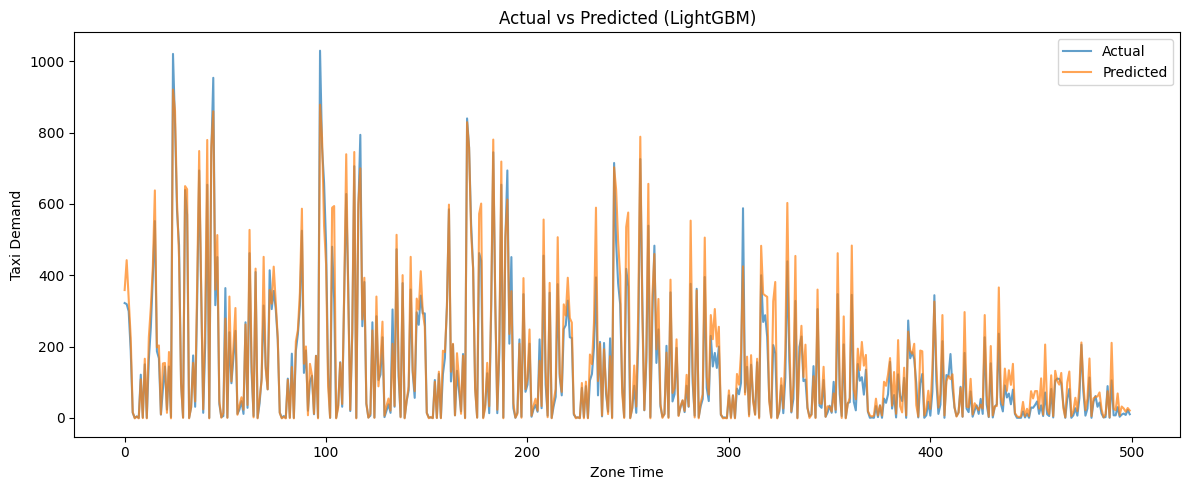

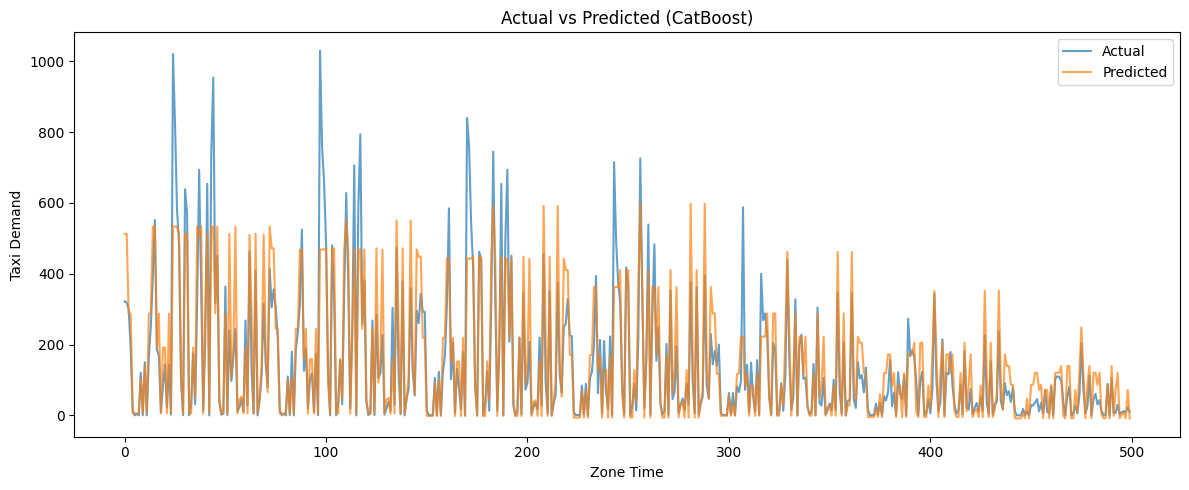

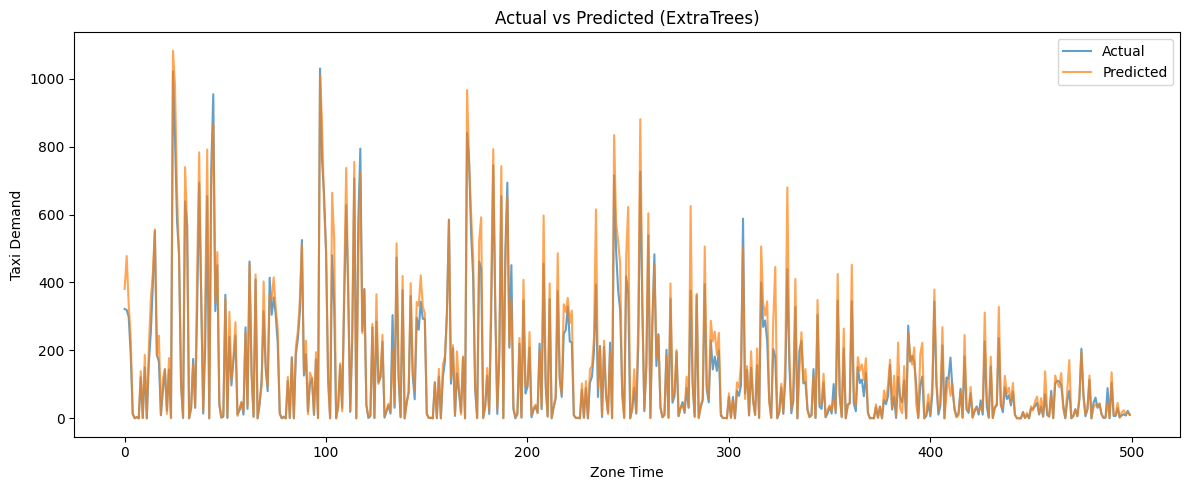

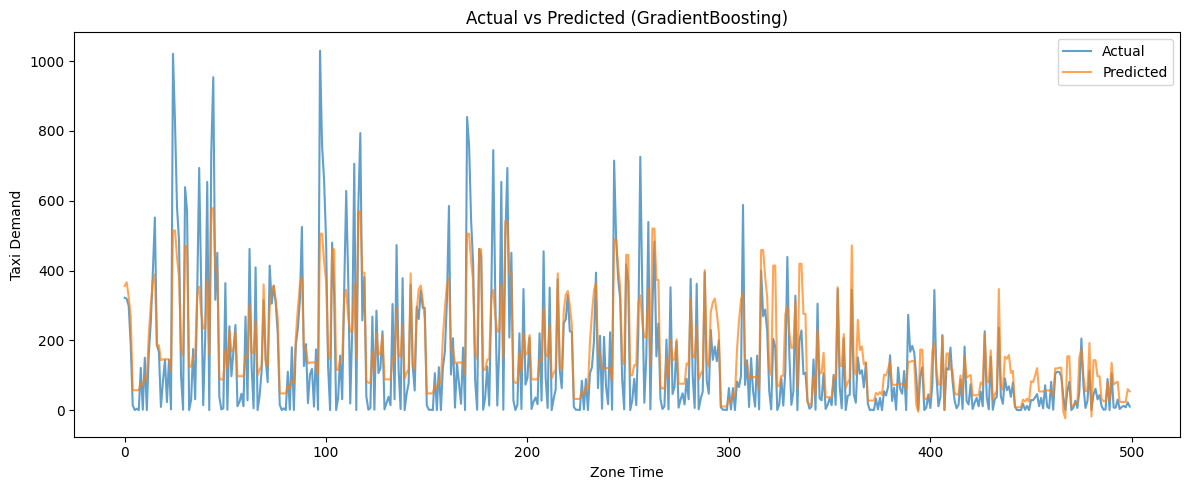

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 211627, number of used features: 19
[LightGBM] [Info] Start training from score 158.409674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 169301, number of used features: 18
[LightGBM] [Info] Start training from score 160.704745
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

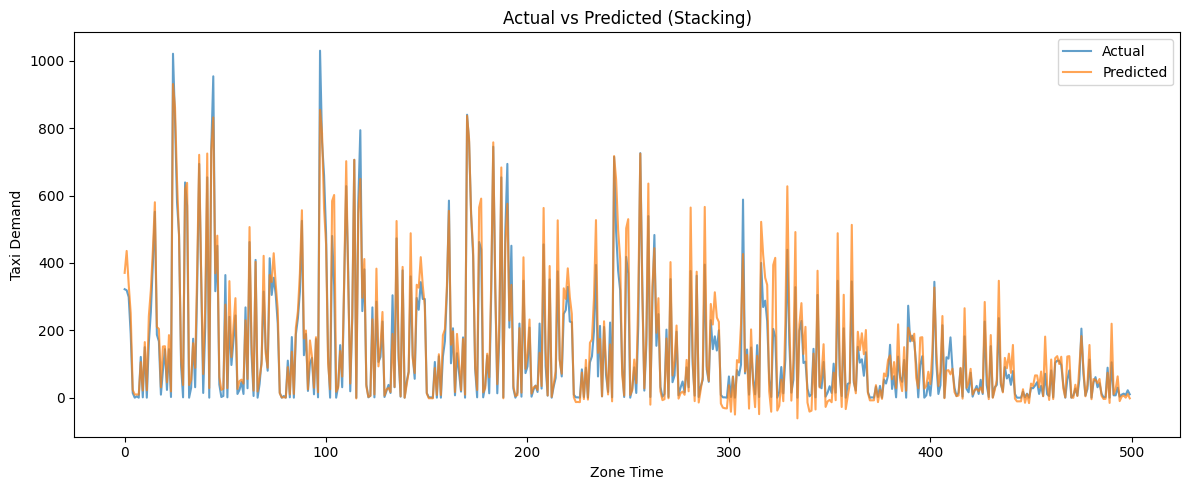

Best model by RMSE: ExtraTrees


In [16]:
# 5. Actual vs Predicted for every trained model, and identify Best Model
import matplotlib.pyplot as plt

# Helper to fit and predict per model with the right dtypes
def fit_and_predict(name, model, X_train, y_train, X_test):
    try:
        if name == 'LightGBM':
            model.fit(X_train, y_train, categorical_feature=['PUZone'])
            y_pred = model.predict(X_test)
        elif name == 'XGBoost':
            X_train_xgb = X_train.copy()
            X_test_xgb = X_test.copy()
            X_train_xgb['PUZone'] = X_train_xgb['PUZone'].astype(int)
            X_test_xgb['PUZone'] = X_test_xgb['PUZone'].astype(int)
            model.fit(X_train_xgb, y_train)
            y_pred = model.predict(X_test_xgb)
        elif name == 'CatBoost':
            X_train_cb = X_train.copy()
            X_test_cb = X_test.copy()
            X_train_cb['PUZone'] = X_train_cb['PUZone'].astype(str)
            X_test_cb['PUZone'] = X_test_cb['PUZone'].astype(str)
            model.fit(X_train_cb, y_train, cat_features=['PUZone'])
            y_pred = model.predict(X_test_cb)
        elif name == 'HybridVoting':
            X_train_h = X_train.copy()
            X_test_h = X_test.copy()
            X_train_h['PUZone'] = X_train_h['PUZone'].astype(int)
            X_test_h['PUZone'] = X_test_h['PUZone'].astype(int)
            model.fit(X_train_h, y_train)
            y_pred = model.predict(X_test_h)
        elif name == 'Stacking':
            X_train_s = X_train.copy()
            X_test_s = X_test.copy()
            X_train_s['PUZone'] = X_train_s['PUZone'].astype(int)
            X_test_s['PUZone'] = X_test_s['PUZone'].astype(int)
            model.fit(X_train_s, y_train)
            y_pred = model.predict(X_test_s)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        return y_pred
    except Exception as e:
        print(f"{name} failed during plotting: {e}")
        return None

# Train on full training set for plotting consistency and make plots for each model
plot_len = min(500, len(y_test))
for name, mdl in models:
    y_pred_m = fit_and_predict(name, mdl, X_train, y_train, X_test)
    if y_pred_m is None:
        continue
    plt.figure(figsize=(12, 5))
    plt.plot(y_test.values[:plot_len], label='Actual', alpha=0.7)
    plt.plot(y_pred_m[:plot_len], label='Predicted', alpha=0.7)
    plt.title(f'Actual vs Predicted ({name})')
    plt.xlabel('Zone Time')
    plt.ylabel('Taxi Demand')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Determine best model from results_df (lowest RMSE)
best_model_name = results_df.sort_values('RMSE', ascending=True).iloc[0]['Model']
print(f"Best model by RMSE: {best_model_name}")



In [47]:
# Save the best model as a pickle file
import pickle
best_model_name = results_df.iloc[0]['Model']
best_model = [m for n, m in models if n == best_model_name][0]
# Refit on all training data for best accuracy
if best_model_name == 'LightGBM':
    best_model.fit(X_train, y_train, categorical_feature=['PUZone'])
elif best_model_name == 'XGBoost':
    X_train_xgb = X_train.copy()
    X_train_xgb['PUZone'] = X_train_xgb['PUZone'].astype(int)
    best_model.fit(X_train_xgb, y_train)
elif best_model_name == 'HybridVoting':
    X_train_hybrid = X_train.copy()
    X_train_hybrid['PUZone'] = X_train_hybrid['PUZone'].astype(int)
    best_model.fit(X_train_hybrid, y_train)
else:
    best_model.fit(X_train, y_train)

with open('taxi_demand_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"Best model ({best_model_name}) saved as taxi_demand_model.pkl")



Best model (HistGradientBoosting) saved as taxi_demand_model.pkl


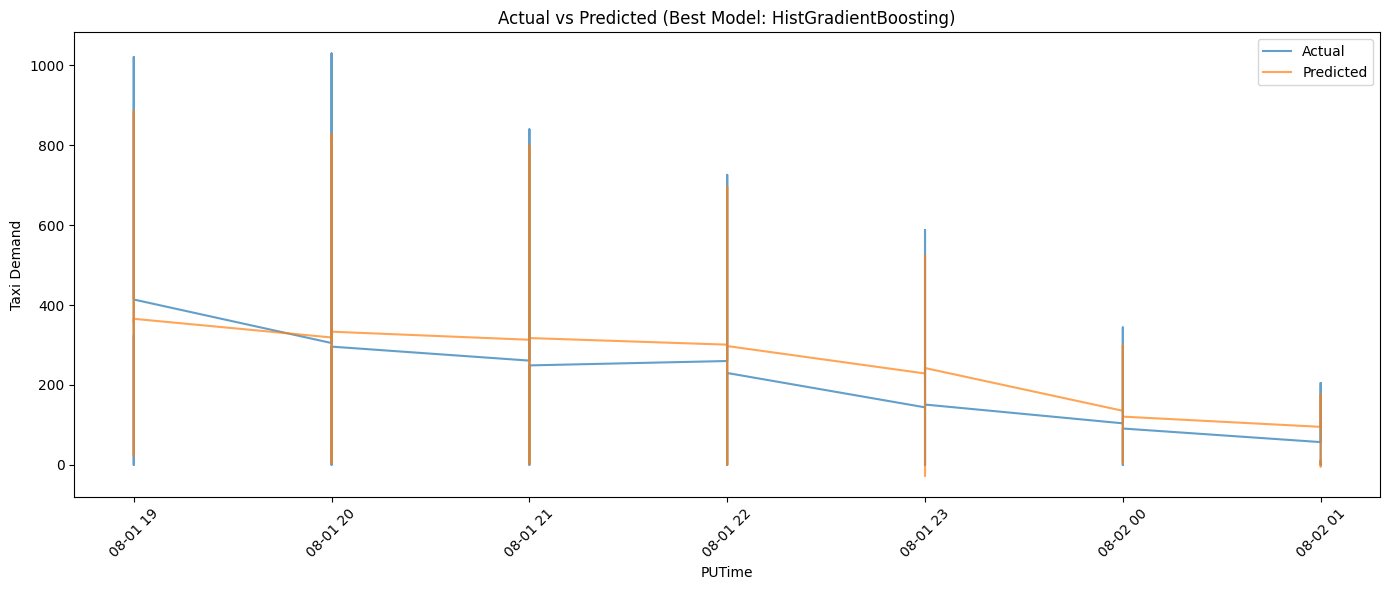

In [53]:
# Time series Actual vs Predicted for Best Model (recompute predictions on feature_cols only)
import matplotlib.pyplot as plt

# Determine best model by RMSE
best_model_name = results_df.sort_values('RMSE', ascending=True).iloc[0]['Model']
best_model = [m for n, m in models if n == best_model_name][0]

# Always predict using the exact training feature set
X_train_sel = X_train[feature_cols].copy()
X_test_sel = X_test[feature_cols].copy()

# Fit and predict with appropriate dtype handling
if best_model_name == 'LightGBM':
    best_model.fit(X_train_sel, y_train, categorical_feature=['PUZone'])
    y_pred_best = best_model.predict(X_test_sel)
elif best_model_name == 'XGBoost':
    X_train_xgb = X_train_sel.copy(); X_test_xgb = X_test_sel.copy()
    X_train_xgb['PUZone'] = X_train_xgb['PUZone'].astype(int)
    X_test_xgb['PUZone'] = X_test_xgb['PUZone'].astype(int)
    best_model.fit(X_train_xgb, y_train)
    y_pred_best = best_model.predict(X_test_xgb)
elif best_model_name == 'CatBoost':
    X_train_cb = X_train_sel.copy(); X_test_cb = X_test_sel.copy()
    X_train_cb['PUZone'] = X_train_cb['PUZone'].astype(str)
    X_test_cb['PUZone'] = X_test_cb['PUZone'].astype(str)
    best_model.fit(X_train_cb, y_train, cat_features=['PUZone'])
    y_pred_best = best_model.predict(X_test_cb)
else:
    X_train_g = X_train_sel.copy(); X_test_g = X_test_sel.copy()
    if 'PUZone' in X_train_g.columns:
        try:
            X_train_g['PUZone'] = X_train_g['PUZone'].astype(int)
            X_test_g['PUZone'] = X_test_g['PUZone'].astype(int)
        except Exception:
            pass
    best_model.fit(X_train_g, y_train)
    y_pred_best = best_model.predict(X_test_g)

# Ensure PUTime present for plotting timeline
if 'PUTime' not in X_test.columns:
    X_test = X_test.copy()
    X_test['PUTime'] = merged.loc[X_test.index, 'PUTime']

plt.figure(figsize=(14, 6))
idx = slice(0, min(500, len(y_test)))
plt.plot(X_test['PUTime'].iloc[idx], y_test.values[idx], label='Actual', alpha=0.7)
plt.plot(X_test['PUTime'].iloc[idx], y_pred_best[idx], label='Predicted', alpha=0.7)
plt.title(f'Actual vs Predicted (Best Model: {best_model_name})')
plt.xlabel('PUTime')
plt.ylabel('Taxi Demand')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


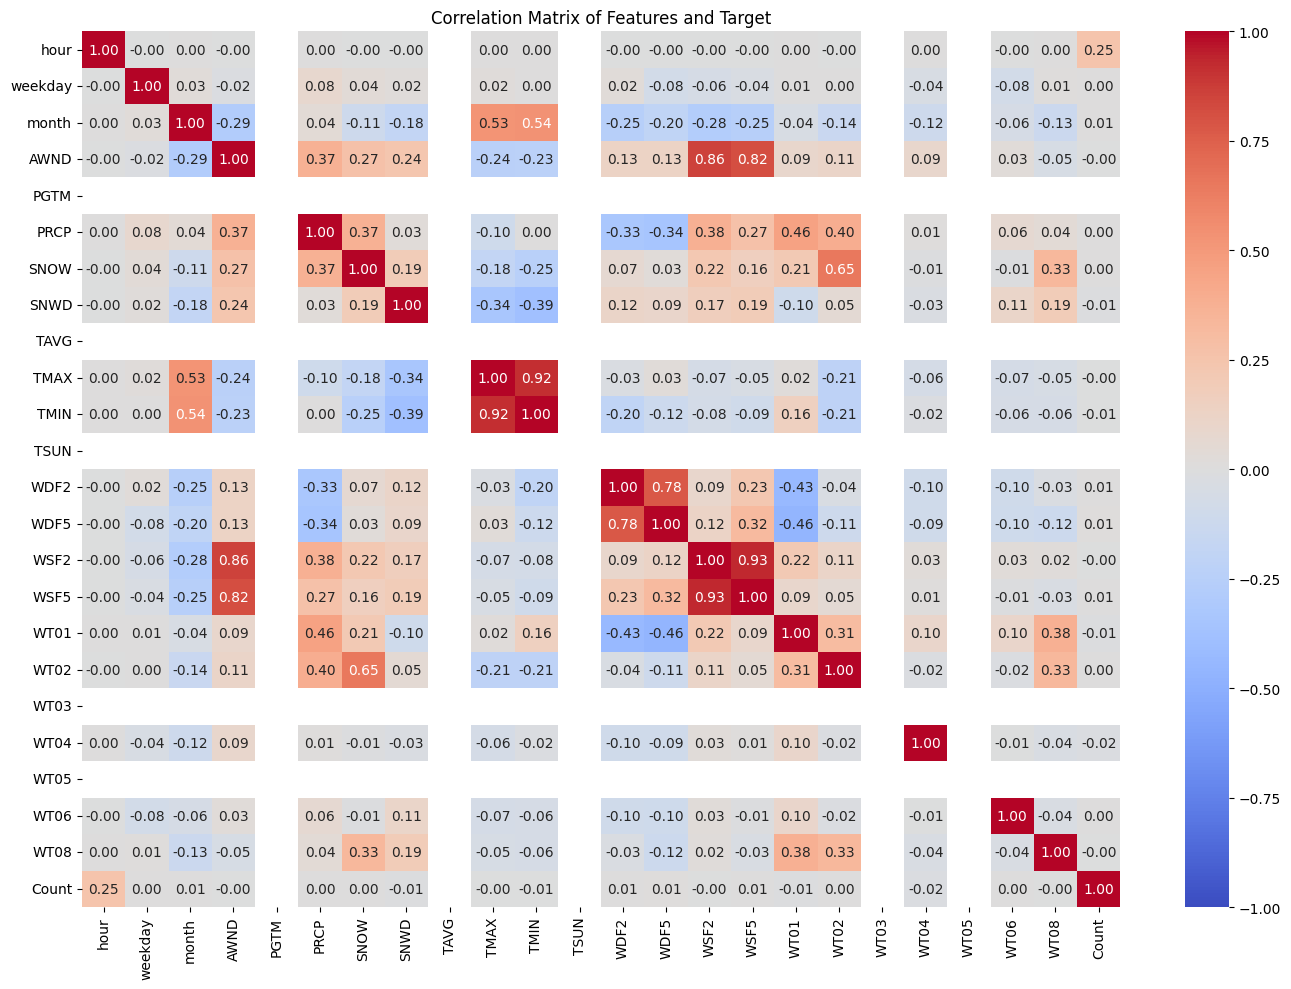

In [54]:
# Correlation matrix for features
import seaborn as sns
corrmat = merged[feature_cols + [target_col]].corr(numeric_only=True)
plt.figure(figsize=(14, 10))
sns.heatmap(corrmat, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features and Target')
plt.tight_layout()
plt.show()



C:\Users\rathi\AppData\Local\Temp\ipykernel_23352\3349033719.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results_df_sorted, palette='viridis')


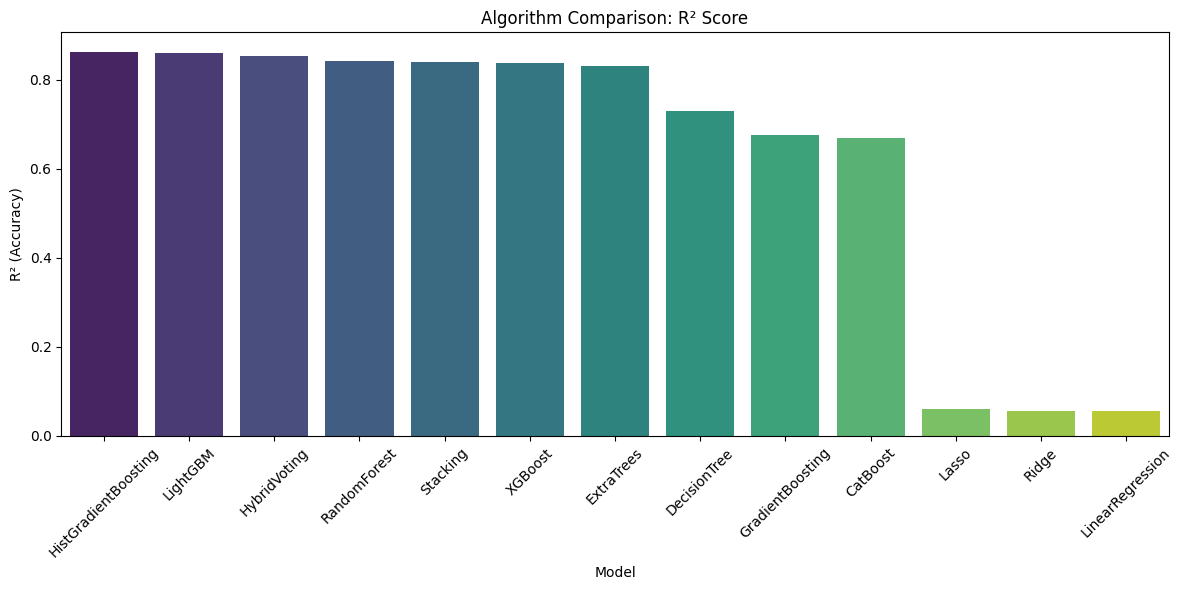

C:\Users\rathi\AppData\Local\Temp\ipykernel_23352\3349033719.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results_df_sorted, palette='Blues_r')


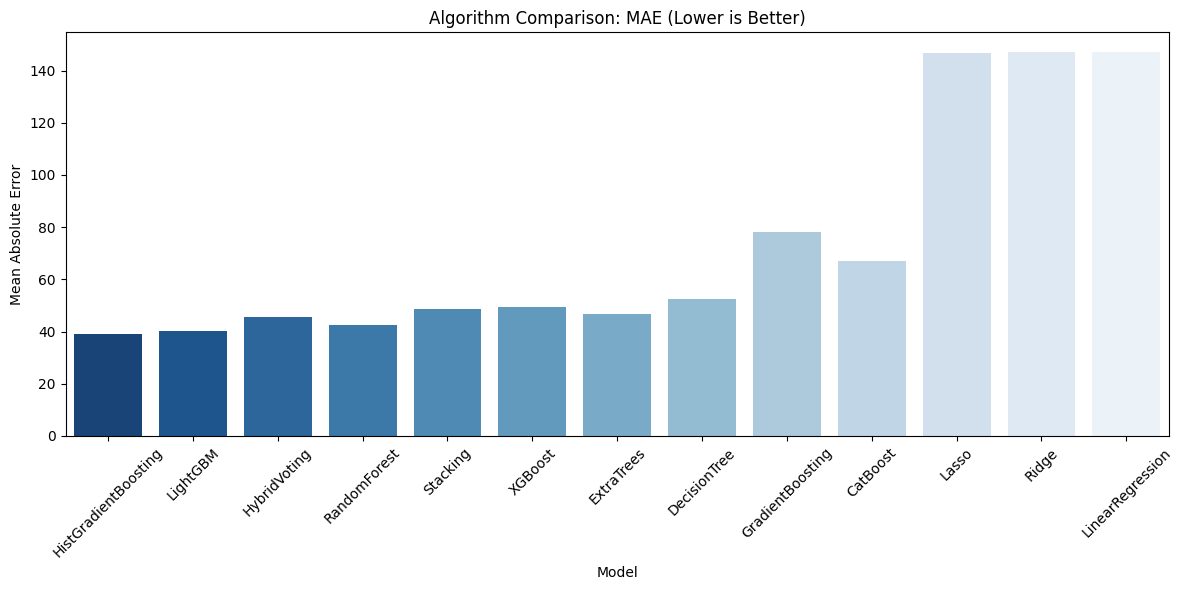

C:\Users\rathi\AppData\Local\Temp\ipykernel_23352\3349033719.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df_sorted, palette='Oranges_r')


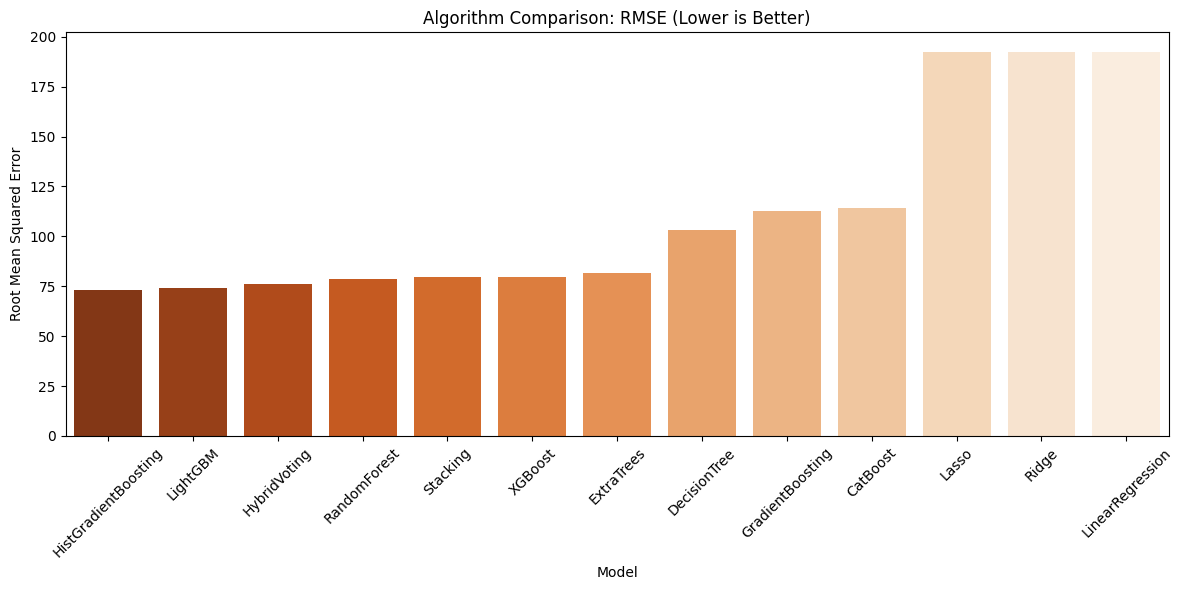

In [37]:
# Performance metrics and algorithm accuracy comparison graphs
results_df_sorted = results_df.sort_values('R2', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2', data=results_df_sorted, palette='viridis')
plt.title('Algorithm Comparison: R² Score')
plt.ylabel('R² (Accuracy)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MAE', data=results_df_sorted, palette='Blues_r')
plt.title('Algorithm Comparison: MAE (Lower is Better)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=results_df_sorted, palette='Oranges_r')
plt.title('Algorithm Comparison: RMSE (Lower is Better)')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [3]:
# Use the best trained model to predict demand for test cases (no raw prints here)
import pickle
import pandas as pd
import numpy as np

# Ensure weather and weather_cols exist even after fresh kernel start
try:
    weather
    weather_cols
except NameError:
    # Load weather and prepare columns
    weather = pd.read_csv('data/weather_2025.csv')
    def parse_weather_date(x):
        try:
            return pd.to_datetime(x, format='%m/%d/%y')
        except Exception:
            return pd.to_datetime(x)
    weather['DATE'] = weather['DATE'].apply(parse_weather_date)
    weather['date'] = weather['DATE'].dt.date
    weather_cols = weather.columns.drop(['DATE', 'date'])


def predict_demand_with_model(model, zone, date_str, hour, weather_df=weather):
    date = pd.to_datetime(date_str)
    weekday = date.weekday()
    month = date.month
    # Find weather for this date
    w = weather_df[weather_df['date'] == date.date()]
    if w.empty:
        w = pd.DataFrame([np.zeros(len(weather_cols))], columns=weather_cols)
    else:
        w = w[weather_cols]
    features = pd.DataFrame([
        {
            'PUZone': zone,
            'hour': hour,
            'weekday': weekday,
            'month': month,
            **dict(zip(weather_cols, w.iloc[0]))
        }
    ])
    # Handle categorical/int for PUZone as needed
    if hasattr(model, 'predict') and hasattr(model, 'fit'):
        if model.__class__.__name__ == 'LGBMRegressor':
            features['PUZone'] = features['PUZone'].astype('category')
        elif model.__class__.__name__ == 'CatBoostRegressor':
            features['PUZone'] = features['PUZone'].astype(str)
        else:
            features['PUZone'] = features['PUZone'].astype(int)
    return model.predict(features)[0]

# Load the best model from pickle
with open('taxi_demand_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Raw predictions are intentionally not printed here.



In [4]:
# Human-readable predictions: PUZone -> Hub and taxis needed (integer only)
import json
from pathlib import Path

# Load hub->zone mapping saved by scripts/generate_zone_files_from_raw.py
hub_to_zone_path = Path("data/hub_to_zone.json")
if hub_to_zone_path.exists():
    with open(hub_to_zone_path, "r", encoding="utf-8") as f:
        hub_to_zone = json.load(f)
else:
    hub_to_zone = {}

# Build reverse map: zone(int) -> hub(str)
zone_to_hub = {}
for hub, z in hub_to_zone.items():
    try:
        z_int = int(z)
    except Exception:
        continue
    if z_int not in zone_to_hub:
        zone_to_hub[z_int] = hub

def get_hub_name(zone_id: int) -> str:
    return zone_to_hub.get(int(zone_id), "Unknown hub")

def predict_taxis_needed(model, zone_id: int, date_str: str, hour: int) -> int:
    y_pred = predict_demand_with_model(model, zone_id, date_str, hour)
    taxis_needed = max(0, int(round(float(y_pred))))
    return taxis_needed

def show_prediction(model, zone_id: int, date_str: str, hour: int):
    hub_name = get_hub_name(zone_id)
    taxis_needed = predict_taxis_needed(model, zone_id, date_str, hour)
    print(f"Zone {zone_id} ({hub_name}) @ {date_str} {hour:02d}:00 -> Taxis needed: {taxis_needed}")

# Example test cases (no raw floats printed)
show_prediction(loaded_model, 5,  "2025-08-15", 14)
show_prediction(loaded_model, 10, "2025-08-20",  9)
show_prediction(loaded_model, 30, "2025-08-01", 18)
show_prediction(loaded_model, 50, "2025-08-25", 23)



Zone 5 (Alagapuram Junction) @ 2025-08-15 14:00 -> Taxis needed: 0
Zone 10 (Anna Nagar Roundtana (East)) @ 2025-08-20 09:00 -> Taxis needed: 166
Zone 30 (Chennai International Airport (T1/T4) – Gate Pickup) @ 2025-08-01 18:00 -> Taxis needed: 623
Zone 50 (Erode Municipal Corporation Office) @ 2025-08-25 23:00 -> Taxis needed: 202
